# Continuous Control with Deep Reinforcement Learning


## OpenAI Bipedal Walker 

  This is simple 4-joints walker robot environment.
 
  There are two versions:
 
  - **Normal**, with slightly uneven terrain.
 
  - **Hardcore** with ladders, stumps, pitfalls.
  


<table><tr>
<td> <img src="images/normal_env.png"  style="width: 550px;"/> </td>
<td> <img src="images/hardcore_env.png"  style="width: 550px;"/> </td>
</tr></table>
  
  
  
We are using the Normal environment to prototype the Deep Deterministic Policy Gradient (DDPG).


#### Source

  The BipedalEnvironment was created by Oleg Klimov and is licensed on the same terms as the rest of OpenAI Gym.  
  Raw environment code: https://github.com/openai/gym/blob/master/gym/envs/box2d/bipedal_walker.py  


### Rewards Given to the Agent

  - Moving forward, total 300+ points up to the far end. 
  - If the robot falls, it gets -100. 
  - Applying motor torque costs a small amount of points, more optimal agent will get better score.

### State Space: 24 Dimensions

  - **4 hull measurements**: angle speed, angular velocity, horizontal speed, vertical speed
  - **8 joint measurements**, 2 for each of the 4 joints: position of joints and joints angular speed 
  - **2 leg measurements**, one for each leg: legs contact with ground
  - **10 lidar rangefinder measurements** to help to navigate the hardcore environment. 
  
### What quantifies a solution, or a sucessful RL agent?
  
  To solve the game you need to get **300 points in 1600 time steps**.
 
  To solve the hardcore version you need **300 points in 2000 time steps**.



In [54]:
from agents import Agent
import tensorflow as tf
import os
import gym
import numpy as np
import matplotlib.pyplot as plt

ImportError: cannot import name 'Agent' from 'agents' (C:\Users\Stephen\Desktop\Work\COGS 182\Project2\agents.py)

## Architecture
https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FDeep-Deterministic-Policy-Gradient-DDPG-algorithm-structure_fig3_338552761&psig=AOvVaw2-8GJu9oPAVBTyJGsAmmXW&ust=1615873096160000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCICv4cfKse8CFQAAAAAdAAAAABAD

### REINFORCE
http://www.cs.toronto.edu/~guerzhoy/411/proj4/bipedal-reinforce.py

Instead of output a deterministic policy, a single value for each feature of our action vector, we will output a stochastic deterministic policy, that is, a probability distribution for each feature of our action vector.

## Critic Loss Function

Update the critic network by minimizing the loss:

$L = \frac{1}{N}\sum(y_i - Q(s_i, a_i | \theta^Q))^2$

where the target $y_i$ is equal to:
$y_i = r_i + \gamma Q'(s_{i+1}, \mu'(s_{i+1}|\theta^{\mu'})|\theta^{Q'})$

This target is reminiscent of the update target in Q-learning, except we are substituting the known Q' values with output values from our Target Critic Network.

### Intuition
Any time we see the term $\mu(s|\theta^{\mu'})$, we should recognize that its similar to an action, $a$, except it is the output action of feeding a state $s$ into the Target Actor Network, given the target network's current weights $\theta^{\mu'}$.

To compute the Q value $Q'(s_{i+1}, \mu'(s_{i+1}|\theta^{\mu'})|\theta^{Q'})$ for this $\mu'(s_{i+1}|\theta^{\mu'})$, we feed $s'$ and $\mu'(s_{i+1}|\theta^{\mu'})$ into the Target Critic Network, since critics are responsible for generating values for a given state and action. Thus, we get $Q'(s'_{i+1},\mu'(s_{i+1}))$, and update the model using the MSE between this and the Critic Network's Q output for state $s$ and action $a$.
            
            
## Actor Loss Function

## Weight Updates

DDPG uses conservative policy iteration (soft updates) on the actor and critic network weights. Another term for this is Polyak Averaging.  

For example, if $\theta^Q$ is the critic network weights then:  

$\theta^{Q'} = \rho\theta^Q + (1-\rho)\theta^{Q'}$
where $\rho$ << 1


## Exploration Strategy
Add noise to the action, since the action space is continuous:

$\mu'(s) = \mu_\theta(s) + \mathcal{N}$

By adding noise, we can separate the exploration strategy from our policy. The noise employed here is generated based upon an Ornstein-Uhlenbeck process which allows for temporally correlated exploration for physical control problems involving inertia.

# Pendulum Environment: Proof-of-Concept

In [55]:
env_name = 'Pendulum-v0'

env = gym.make(env_name)
agent = Agent(env=env, env_name = env_name, layer_dims = (400,300), batch_size = 64, 
              rho = 0.01, gamma = 0.95, lr_critic= 0.005, lr_actor= 0.003, b_normalize = False)
score_history = train(agent, env, episodes = 100, debug = False, 
                           save = True)

Ep:  0 Score -1114.3 Avg -1114.3 Actions: 200
Ep:  10 Score -701.9 Avg -1174.6 Actions: 200
Ep:  20 Score -665.9 Avg -903.5 Actions: 200
Ep:  30 Score -124.6 Avg -694.9 Actions: 200
Ep:  40 Score -247.9 Avg -567.3 Actions: 200
Ep:  50 Score -137.8 Avg -494.3 Actions: 200
Ep:  60 Score -128.6 Avg -436.6 Actions: 200
Ep:  70 Score -130.1 Avg -394.5 Actions: 200
Ep:  80 Score -134.8 Avg -289.5 Actions: 200
Ep:  90 Score -126.9 Avg -196.7 Actions: 200


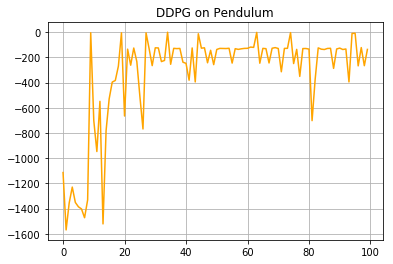

In [56]:
plt.title("DDPG on Pendulum")
plt.plot(score_history, c = 'orange', label = 'DDPG')
plt.grid()

In [ ]:
## Render 5 episodes to view policy!
evaluate=True
_ =train(agent,env,episodes=5, debug=False, save=False, evaluate=evaluate)

## Bipedal Environment

In [58]:
def train_walker(agent, env, episodes = 200, epsilon = 0, debug = True, save = True, 
          load_checkpoint = False, evaluate = False):
    
    
    score_history = []
    raw_reward_history = []
    best_score = env.reward_range[0]
    
    if load_checkpoint:
        n_steps = 0
        while n_steps <= agent.batch_size:
            observation = env.reset()
            action = env.action_space.sample()
            observation_, reward, done, info = env.step(action)
            agent.remember_experience(observation, action, reward, observation_, done)
            n_steps += 1
        agent.learn()
        agent.load_weights()
      


    ## Game Loop
 
    for i in range(episodes):
        state = env.reset()[:14]
        terminal = False
        score = 0
        raw_reward =0 
        action_sequence = []

        while not terminal:
            
            if evaluate:
                env.render()
                
            action = agent.compute_action(state, epsilon, evaluate = evaluate)
            action_sequence.append(action)
            
            state_p, reward, terminal, info = env.step(action)
            state_p = state_p[:14]
            
            raw_reward += reward
            
            # Modifications to avert agent from learning to sit still
            #if (state_p[3] - state[3]) < 0.001:
            #    reward += -10
            score += reward
            


            agent.remember_experience(state, action, reward, state_p, terminal)

            if not evaluate:
                agent.learn()
            else:
                print(reward)

            state = state_p


        score_history.append(score)
        raw_reward_history.append(raw_reward)
        avg_score = np.mean(raw_reward_history[-75:])

        if avg_score > best_score:
            best_score = avg_score
            if save:
                agent.save_weights(debug=debug, iteration=i)

        if debug:
            print('Ep: ', i, 'Raw Score %.1f'% raw_reward, 'Score %.1f' % score, 'Avg %.1f' % avg_score, 
                  'Actions:', len(action_sequence))
        elif i % 10 == 0:
            print('Ep: ', i, 'Raw Score %.1f'% raw_reward, 'Score %.1f' % score, 'Avg %.1f' % avg_score, 
                      'Actions:', len(action_sequence))
    if evaluate:
        env.close()
        
    return score_history, raw_score_history

In [ ]:
env_name = 'BipedalWalker-v2'
env = gym.make(env_name)
agent = Agent(env=env, env_name = env_name, layer_dims = (400,300), batch_size = 128, state_size = 14,
             rho = 0.001, gamma = 0.99, lr_critic= 0.005, lr_actor= 0.003, b_normalize = False)
norm_score_history, raw_history = train_walker(agent, env, episodes = 1000, debug = False, save = True)

Ep:  0 Raw Score -100.9 Score -100.9 Avg -100.9 Actions: 118
Ep:  10 Raw Score -118.6 Score -118.6 Avg -116.6 Actions: 38
Ep:  20 Raw Score -117.4 Score -117.4 Avg -116.5 Actions: 150
Ep:  30 Raw Score -116.3 Score -116.3 Avg -115.3 Actions: 154
Ep:  40 Raw Score -112.0 Score -112.0 Avg -115.5 Actions: 84
Ep:  50 Raw Score -118.1 Score -118.1 Avg -115.9 Actions: 37
Ep:  60 Raw Score -119.0 Score -119.0 Avg -116.8 Actions: 39
Ep:  70 Raw Score -103.5 Score -103.5 Avg -116.6 Actions: 54
Ep:  80 Raw Score -125.1 Score -125.1 Avg -119.9 Actions: 48
Ep:  90 Raw Score -115.2 Score -115.2 Avg -122.2 Actions: 41
Ep:  100 Raw Score -116.0 Score -116.0 Avg -122.9 Actions: 51
Ep:  110 Raw Score -138.8 Score -138.8 Avg -123.6 Actions: 1600
Ep:  120 Raw Score -110.8 Score -110.8 Avg -122.4 Actions: 40
Ep:  130 Raw Score -108.3 Score -108.3 Avg -123.7 Actions: 57
Ep:  140 Raw Score -108.5 Score -108.5 Avg -123.2 Actions: 37
Ep:  150 Raw Score -104.6 Score -104.6 Avg -121.6 Actions: 54
Ep:  160 Raw S

In [50]:
agent.save_weights()


........Initializing save at Episode BipedalWalker-v2_models........
Saving Actor, Critic, and Target Networks..................


In [52]:
## Render 5 episodes to view policy!

env.close()
_ =train_walker(agent,env,episodes=10, debug=False, save=False, evaluate=True)

-0.2838327605631203
0.026558993020094915
-10.20955156216367
0.007056534164275919
-10.188262441541378
-0.039560937718801086
-10.211250390349575
-0.022941877628367337
0.024096444790560802
-0.04859511849035701
-10.079752792697866
-0.07209545829876518
-0.14803329786751418
-0.12833016543835402
-0.13136660574873527
-0.16572760385771473
-0.14963786748051644
-0.12402040227254113
-0.007247356861829764
-0.0183177257180214
-0.02910390611489851
-0.035624765257038296
-0.038954252595703995
-0.040319119719166366
-0.03927996526907006
-0.03366875873506069
-0.023052642658352853
-0.011288301664095314
-10.011551769167184
-0.07418780983487529
-10.05878546410675
-0.06402232447390636
-0.04706471902318299
-10.184231278832383
-0.051293300837278365
-0.07131013853847981
-10.064218897446677
-0.08982189700286837
-0.07478473390328505
-0.04913131804205477
-0.1430557289260141
-10.042939648610849
-0.06005312299231806
-0.10198249298334121
-0.0786262345686555
-0.07821618823210162
-0.07604240644971648
-0.0726599722571372

0.07569401995341456
-10.002560259421676
0.048438586274787546
0.17675189304351804
-10.010478319247559
0.0062596859931945865
0.15148128092288968
-9.929003657420486
0.09742286312580108
0.19589827374617735
-10.007891442894936
0.02067468579609715
0.17887662220001224
0.17487140274047852
0.14807538535198525
0.13129634539285348
0.11053772015373385
0.09109433049957431
0.07543605043490256
0.06300974183280789
0.05320896914601327
0.04676803703109896
0.042468650338545674
0.03975166045005596
0.03811741350963713
0.03737298411379732
0.03857185094554745
0.04364789357781411
0.05210229205091321
0.06341862113277591
0.07755288767814637
0.10193736379344782
0.16760262174159288
0.18393646196028546
-10.062437253341079
0.06523923445740389
-10.065439060598612
0.0050900517304833075
0.06307763862609864
-10.036844985206931
0.10425235289335248
0.14789263304075553
-10.05447375925383
-0.0019134170413017265
0.11127709162235258
0.08182325291633606
0.08193856066963029
0.0785929338564165
0.07181739847362041
0.064986732721

0.1481309621334076
0.1678331966996193
0.1960533795952797
0.22683928354582145
0.2924211749136448
-9.745895135795086
0.23387239068993965
-9.957934967510402
0.03108299169442012
0.046129178623348935
-9.967510607361794
0.07824303040903714
0.059633246461540904
-9.94511157176891
0.0845809509356627
0.07096509140729905
-9.922612417380005
0.12039696582159352
0.10276970406371447
0.06524362369379356
0.14961088915666892
0.2559628440861711
0.2184353880882263
0.19887750037512136
0.17960069930553435
0.1295714146097596
0.1053390140185659
0.20128167555728602
0.2237019171392019
-10.013317987280578
-0.010409990732877988
0.12268390859538364
-9.986761535320431
0.023190234820066966
-9.980405929602682
-0.004673956093698275
-10.032252384608
-0.014505577837408513
0.004097952385724503
0.02110316749414755
0.0333661081790924
0.04227016904950143
0.04961255127438948
0.059672528420894884
0.04382061479488061
-0.007335380107164383
-9.933595445896179
0.05656358562907529
-0.07678394135337976
-9.951229132359208
0.03980789

0.01301587558785126
0.01846166909983708
0.02134895237101569
0.021930983201892098
0.02185778966796305
0.02169132493692451
-0.007403577215445243
-0.007467500916973674
0.0011361858099698946
0.01860891611623856
0.06238096039619949
0.04976102696234034
-10.096046793542802
0.021606816634535786
-10.161932574853301
-0.008215458363294601
0.05596427723267721
-10.131990315660834
0.012432820906251203
-0.032691848417132637
-0.012170269519090653
-0.004737771232903924
-0.0009399516880512285
0.0014681461254660924
0.0035948407153193786
0.0059427851637299245
0.008703018680214886
0.013572583983332377
0.020805745542049406
0.02935261575382856
0.03967498165863843
0.05021387259135349
0.060688339819520244
0.11378628358989953
-10.141093394055963
0.01835191278654429
-10.142628903458506
0.04247897683581663
-9.95127172204852
0.05210542490083073
0.03411588995656325
0.039262882371753
0.0384140739242141
0.04247341729202911
0.047687089731305386
0.056046463499457105
0.06678613119324996
0.07857504698634149
0.09554816095

-0.05789779469052877
-0.07232563403101092
-0.07765034297791858
-0.07786715268995613
-0.07788630493792158
-0.07774615337513388
-0.07747026838051894
-0.0771721930348613
-0.07697156943256775
-0.07693165978292743
-0.07611781310290099
-0.07398494697113714
-0.07085587040086469
-0.06737958201766014
-0.06391924377779284
-0.060146159857511525
-0.05579545495907584
-0.05105999414125842
-0.04580295823017874
-0.03958727932969848
-0.032292349765695755
-0.024148206422727494
-0.011840581973392574
0.03530625902364414
0.0921229890088252
0.11221793259183682
-10.121221507857245
0.01963777003685752
-10.122339168210827
0.04810717438658316
0.10199563589692116
-10.102391980856657
0.07078376882274826
-9.947656990885735
0.015409075766801828
0.014386179275810724
0.01541592340667923
0.017063513567052664
0.02302527287105483
0.03269294251998502
0.043901812106370924
0.057851513542234896
0.07035670607040088
0.13068580784648656
-10.130138804783423
0.013408786733944016
-10.131930594911177
0.05034124298890313
0.06743910

0.029767454261571628
0.03287592414519144
0.036550143815577016
0.04552508551441134
0.06436028418564843
-0.0010838925950229185
-10.072272362145275
-0.02660956761738612
-9.940703700564802
-0.00241927351926291
-0.12713830842450263
-10.131161477064088
-0.08707364308834077
-0.03994243052601815
-10.127105304618686
-10.113591682910918
0.015586767991393354
0.04814547771215439
0.044998668869331716
0.055171996206045154
0.0493919240633694
0.04279588299989699
0.035725422422081696
0.0285454543530941
0.021591274152204167
0.014836689402654996
0.008030955324575074
0.0021231107910426733
-0.0006038638949394312
-0.0004567110588105869
0.004969546442225799
0.011337714880704883
0.019854873716831208
0.03045662956437423
0.04329802783329809
0.05880687459309421
0.07691846360763863
0.09784484324851678
0.12873457696041418
0.166973547001675
0.25910557713110766
-9.777258819927766
0.20654248779018247
-9.98923420932889
0.04054626670479776
0.04022109198570253
-9.975466180860996
0.054198178569480546
0.05353824098904453


0.1497037519812584
0.14571292708319333
0.141761395663023
0.13732727809745163
0.13340842954319623
0.13709069164592116
0.12369774738949443
0.04572628235816956
-9.851589905987202
0.16799988322457624
-9.857804720305984
-0.04385070244612825
-0.043128629222512246
-10.058150482942642
-0.018539728264032877
0.062412623763084416
-10.106005247950554
-0.06957091315585467
0.10630405131974863
0.06417790879806831
0.08021199528375314
0.0812113253822024
0.07850054679811001
0.074310873006762
0.07065252446135833
0.06881865448257281
0.06995070316642524
0.07313523682081746
0.07779716088375403
0.08487479339540005
0.09438800266385079
0.10643729264536546
0.12158667857447311
0.1429994437496057
0.18119201288619685
0.26613494326174253
-9.969886042952538
0.13293930335840537
0.06924206984043123
-9.936715996782004
0.0750012432734361
0.0703538874387741
-9.932287957787514
0.09700992711383195
0.13284935212135315
-9.960564391334833
0.10283270389834091
0.04900107127428055
0.19033072454729721
0.12260681323212294
0.104330

0.14423564062020136
-9.922452579441188
0.07664700226485728
-10.061174646909029
-0.08413054030388592
-0.1004121169249122
-10.124487011651217
0.043383442898600834
0.05927258898815466
-10.115818998734175
-0.00940956119695352
0.01455300456285476
0.032781886041164394
0.043855669577925936
0.05017389755943464
0.05232738973325445
0.050292502050579516
0.048149697323649675
0.04584834884604766
0.045483142564684616
0.05002368684858084
0.05748400987437322
0.06657574333497929
0.07837269718945028
0.09262109671035454
0.11010767985385564
0.1319921916127205
0.16550678847232506
0.19366696608066558
0.26012305184206325
-9.75972729575634
0.21252810541787792
0.1764582673311233
-9.986851723512023
0.08164958608150483
0.06687790954113006
-9.966564686616243
0.09271432495117188
0.08384535010653826
0.1254644769827714
0.150887736956269
0.21491257633766486
0.2181572165613184
0.2035495891894093
0.17988316291570663
-9.895450851837813
0.15412611879408358
0.27758215037983563
-9.920118427793204
0.09986906480789182
0.2471

0.10836586982011792
0.14192180061340331
0.1852609815597534
0.2600404711167029
-9.769340064644814
0.21270317288239673
0.1689336409767457
-9.844896633446217
0.09211657810956239
0.04651385682821274
0.0909171968301161
0.1534928593238183
0.1543767504443713
0.1349378360311202
0.13330595660209657
0.13024241168797016
0.12800349396963795
0.09101013984189915
-9.971413387874764
0.058145814140636534
-9.99196303786834
0.06195950601498404
0.21249712322155398
-9.982928535858788
0.08073596251010895
0.20177099533875661
-9.976339582622051
0.1582771721382924
0.24311995791892327
-9.967998861913879
0.160040951301653
0.0809482223652303
0.0071260259337723245
0.017156423255801197
0.027851556867361068
0.038029964049656
0.04676451189319411
0.05392922471960268
0.05950041766961654
0.06350093420843403
0.06617437056203208
0.06757078592789906
0.06829384686300914
0.06877118098984637
0.06932737689961516
0.06999667189146556
0.029819150629140544
0.022142353198178238
0.029486429331205675
0.03952994515746831
0.05204923871

-9.992975246429447
0.0542143106857983
0.18714907737572511
-9.995127128084496
0.11922418141365052
0.21003945519526324
-9.996767341117062
0.12767772032817443
0.14060234137375677
0.14073358312249185
0.1337441781957968
0.12425650379309813
0.11287525782486041
0.10117582088708879
0.08969683301448822
0.07842313818633558
0.06741137039661409
0.05677513664463918
0.049029370109244956
0.04479278101027012
0.04283170159657322
0.04268347385898232
0.04378494257728732
0.046873657440141075
0.05193348131577647
0.06004002692301595
0.07240697820981581
0.08844098650415974
0.10761639711260797
0.14123127642273903
0.21639087412754457
-10.066026664296784
0.046809021462992075
-9.991704294105366
0.1301477692921909
-10.052975666046143
0.0746565620303154
0.0637335709830149
0.07979439659913619
0.09705087586243473
0.11198964403073469
0.1268747881253513
0.14408671593666078
0.16834677424033723
0.20454091141621034
0.22161188187202055
0.2703071031371729
-9.75534287929038
0.23462424208968882
-9.96552333355695
0.0274802264

0.23969350764651615
-9.964737236147121
0.04920134978492582
0.05049115241567767
-9.9606074457566
0.06747564961513831
0.06022636036077188
0.11017506664991378
0.1380811959505081
0.16720493480563164
0.10347528634469189
-9.952851946423456
0.08575915474693456
0.2318735827058553
-9.955097378810242
0.10352652808278798
0.07615157111981556
0.018543240440397995
0.03834264725942933
0.05354332056641581
0.06533581039309501
0.07462075786292553
0.08127073956529773
0.08582673945029104
0.08868538399413228
0.09046083411823191
0.09113480703051038
0.06458500379866756
0.07008366373120203
0.08765647759784781
0.12511722303430717
0.11871807448068307
-10.035551540200904
0.031078894689679157
0.1371067211081537
-10.104768099531531
0.07795104287068523
0.01702695832650341
0.0435590768456459
0.07082026217380213
0.09555371010303497
0.11797192734479907
0.13705766854684034
0.1509115304847511
0.16531231425206339
0.21149858849246825
-9.866246447235346
0.12766485164067107
0.0961984909325838
-10.03842655596137
0.0025125472

0.07922897056740431
0.087650192797184
0.09570538594323491
0.1031671064297548
0.10945096255341219
0.11368422942361192
0.11610550804465354
0.11680817590904145
0.11740641424554678
0.11771670512360241
0.11630168472975491
0.11424427088536321
0.09829285565731721
0.07604042573986249
0.09425262650474905
0.12986472053331044
0.17271187515836206
-10.064682714122348
0.027736670240759844
-10.010798885444819
0.11804503020644187
-10.085973764727504
0.023671311179787383
0.032979892790317544
0.05679997414350511
0.0788477765917778
0.09572064844769146
0.11039192036786721
0.12435253024101259
0.14284332976737665
0.16712630597752243
0.20156607428193093
0.27825871042409583
-9.97589451154074
0.12852712080877926
0.0712410580913131
-9.927387512246758
0.03264258257547067
0.026475383520126346
-9.97540927084288
-9.90642318145433
0.1675651390155251
0.15864465598264382
0.14918659939369514
0.14279263269901277
0.1416666882634163
0.1464270291030407
0.1580144930456886
0.17426479716104176
0.20209083471694636
0.2133475199

-10.03535289468366
-0.08040498594444899
0.07209017880758598
-10.053606963674218
0.122423903465271
0.15833227984109569
-10.03568418474993
0.11619450640678405
0.11669490206241609
0.14752019941806793
0.15700598669052124
0.16536603384715226
0.16408068041998242
0.15791527285179452
0.15184498595198942
0.14956724385419534
0.1526426465883851
0.15955287761613726
0.16977914023399354
0.1883209663728778
0.22636993763846067
0.2978401898542945
-9.941825575153024
0.13188027985891654
0.1014656219084868
-9.909421942154585
0.09399418557190711
0.09779865209257785
-9.911950078129768
0.06836262929439545
0.19327466018998438
-9.944236280043958
0.11403259573382045
0.18296344428509476
0.14561013323068617
0.1393295346299997
0.13659651341039034
0.1380509707729211
0.14948203182220463
0.178408262650134
0.21979588754975615
0.27101046566164677
0.318217561841011
0.2938779271444064
-9.734980912526487
0.2246538726190915
-9.883132797002792
0.17920035425823838
0.3296703249812126
-9.87571032744646
0.14624422617751454
0.29

0.14534485905368652
0.15408494051515287
0.16903260651230811
0.19931880013147754
0.2182579001188278
0.2817221547464506
-9.75284880861143
0.2324532798541113
0.10931741970901214
-9.933443872215845
0.16441839474687736
0.155867994363114
-9.863453531168714
0.06152965693207073
0.059685542106628416
-9.953762604812786
0.08720657152931369
0.0746826451420784
0.05335683443148456
0.04163411128520965
0.0301358841757027
0.022526451448597124
0.0174817214012146
0.013326981643833336
0.011241902959845847
0.015948990086406347
0.14577957363922917
0.09313791213929652
0.009803214311599737
0.04395569543044245
-10.022460932095848
0.12345481240749359
0.10417780043681701
0.10286090399324894
0.10193700987224304
0.10223065274271347
0.10846261858008802
0.14646103354729714
0.20040778732547923
0.1889279797375202
-10.05055744972825
0.10525436074534815
0.18424995537102218
-10.028215535253286
0.10791363490124779
0.11461291062583764
-9.965638346695036
0.049949558807536966
-0.1288067446127534
-9.97620740683873
0.074515652

0.07075476415951573
0.06461601142089045
0.06899180505672142
0.08106563186645509
0.10114623280304648
0.11849658353626728
0.09944990841548124
0.22206250178813935
0.24017136426766236
0.1932084093093872
0.2067537920475006
0.2437366411834955
0.24257015748818245
0.21880580204725264
-9.840597794969872
0.09303740006685257
-9.857596873263523
0.05956983882188797
-9.833984073519707
0.1282440002063958
-9.87680855296056
0.27749024965366675
0.32717706833282156
-9.866468376437814
0.2794900331199169
0.2641879848614335
-9.873065610684455
0.02644470221796678
-0.014489460806042423
-9.869492986818164
0.11521750619015052
-0.015164063235133432
-0.011989516178757414
-0.038126400431006686
-0.02288129999239766
-0.01506005642811931
-0.005084375103309974
-9.99288374582927
0.016042249401419895
0.02759495127201081
0.040450443625450146
0.05436166497071109
0.06214249666531407
0.08194915644328273
0.10977611800034366
0.1338347800572808
0.15340011946359322
0.1673109646638329
0.17692562885084795
0.18149165050499141
0.17

KeyboardInterrupt: 

In [36]:
env.close()

In [ ]:
## Batch v Norm Plot
plt.figure(figsize = (10,6))
plt.plot(score_history, c = 'blue', label = 'standard')
plt.plot(norm_score_history, c = 'Orange', label = "batch_norm")
plt.title("DDPG on the Bipedal Walker")
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Total Score (Sum of Rewards)')
plt.grid()